# Identifying white blood cells using CNN with PyTorch

Identification of blood cells in blood samples is an important test in medical diagnosis to evaluate overall health condition. Traditionally blood cells are identified and counted manually using haemocytometer along with other laboratory equipment's and chemical compounds. Automated methods to detect and classify blood cell have an important medical applications.

For the final project of the course "Zero to GANs" on jovian.ml I decided to choose the White Blood Cells dataset from Kaggel. The goal is to train a Convolutional Neural Network to identify 4 types of white blood cells (eosinophils, lymphocites, monocytes and neutrophils).



Importing required libraries:

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
%matplotlib inline

## Dataset

For training I used 'dataset2-master' TRAIN set of 9957 images or ~2500 images for each blood cell class. For evaluating - TEST set of 2487 images

In [2]:
DATA_DIR = '../input/blood-cells/dataset2-master/dataset2-master'

TRAIN_PATH = DATA_DIR + "/images/TRAIN"
TEST_PATH = DATA_DIR + "/images/TEST"
CSV = DATA_DIR + "/labels.csv"

IMG_SIZE      = 128
BATCH_SIZE    = 32
CLASSES    = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

I use PyTorch Transformations module to resize and crop all images to 128x128 px in the train and test datasets. And also apply some random changes to the image like horizontal flip, vertical flip and rotation so images will be slightly different in each epoch of training, which allows it generalize better.

In [3]:
train_tfms = T.Compose([T.Resize(IMG_SIZE),
             T.CenterCrop(IMG_SIZE),
             T.RandomHorizontalFlip(),
             T.RandomVerticalFlip(),
             T.RandomRotation(50),
             T.ToTensor()
            ])
                      
test_tfms = T.Compose([T.Resize(IMG_SIZE),
            T.ToTensor()])

Dataset has the following structure - one folder for one class. So we can use ImageFolder calss from torchvision to load the data as PyTorch tensors

In [4]:
dataset = ImageFolder(TRAIN_PATH, train_tfms)

Number of images in the training set:

In [5]:
len(dataset)

9957

Let's check some images from dataset:

In [6]:
def show_sample(img, target):
    plt.imshow(img.permute((1, 2, 0)))
    print('Label:', CLASSES[target])

Label: EOSINOPHIL


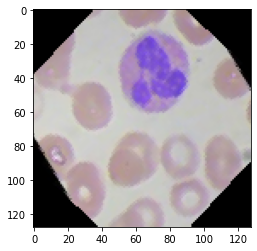

In [41]:
show_sample(*dataset[10])

Label: LYMPHOCYTE


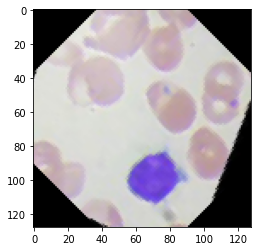

In [7]:
show_sample(*dataset[3000])

## Training, validation and testing sets

Now we need to split our dataset into Training set and Validation set.

**Training set** - used to train the model by computing the loss and adjust the weights of the model using gradient descent.

**Validation set** - used to evaluate the model while training, adjust hyperparameters and pick the best variant of the model.

To ensure that we create the same validation set, we will set a seed for the random number generator. Validation set is 10% of the dataset. So we get 8962 images in training set and 995 images in validation set.

In [8]:
torch.manual_seed(10)

In [9]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [10]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(8962, 995)

**Test set** will be used to report the final accuracy of the model. We don't use these images to train the model

In [11]:
test_ds = ImageFolder(TEST_PATH, test_tfms)
len(test_ds)

2487

## Data Loader

The next step is to create data loaders for training and validation set, to load the data in batches. Each batch containing 32 images.

In [12]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE * 2, num_workers=3, pin_memory=True)

We can visualize a random batch of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different batch, since the sampler shuffles images before creating batches.

In [13]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

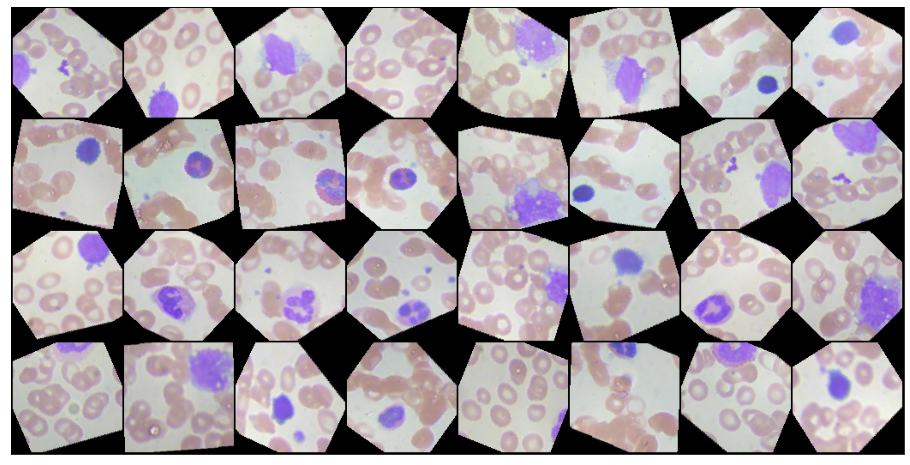

In [14]:
show_batch(train_dl)

## Model

For my model I will use ResNet or residual neural network architecture, 18 layer variant. 
The key feature of which is using residual learning. In traditional neural networks, each layer connects directly. In a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2-3 hops away. This solves the degradation problem, gradient dispersion in deep networks. In addition ResNet is pretrained on the ImageNet dataset.

ImageClassificationBase is a class which contains helper methods for training & validation.

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
       
        out = self(images)

        loss = F.cross_entropy(out, labels)      
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_acc'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Here I define ResNet18 architecture that will be used in my model. In addition I added the last forward connection layer that will give the propbabilities for each of 4 classes

In [15]:
class BloodResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 4)

    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

Here is some helper functions to use GPU if available and DeviceDataLoader class to move model and data to the device. Using GPU for training deep neural networks with many layers is preferable because they are optimized for performing expensive matrix operations on floating point numbers in a short time.

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Now we check which device is available, GPU or CPU, wrap training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the available device and move the model to the device

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [20]:
# model.load_state_dict(torch.load('../input/blood/model.pth'))

In [19]:
model = to_device(BloodResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Here we can check the structure of the model

In [20]:
model

BloodResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Training the model

It's time to train the model. But first implement some additional functions that will improve the learning proccess. 

* Instead of using a fixed learning rate, I will use a **learning rate scheduler**, which will change the learnig rate during training. Here used "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it every batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

* Another regularization technique used is **weight decay**, which prevents the weights from becoming too large by adding an additional term to the loss function.

* **Gradient clipping** - technique which used to limit the values of gradients to small range to prevent undesirable changes in parameters due to large gradient values

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, var_lr=True):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    if var_lr:
        optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
        # Set up one-cycle learning rate scheduler
        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                    steps_per_epoch=len(train_loader))
    else:
         optimizer = opt_func(model.parameters(), max_lr)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            if var_lr:
                sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Let's instantiate the model and see how it performs on the validation set with initial set of parameters:

In [22]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.38336980342865, 'val_acc': 0.2652343809604645}]

The initial accuracy is around 25% which is expected in randomly initialized model (there is 4 classes, 1/4 chance to guesse)

To train the model used the following hyperparameters:

In [23]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func
                         )


Epoch [0], last_lr: 0.0076, train_loss: 1.0105, val_loss: 1.4518, val_acc: 0.2792



Epoch [1], last_lr: 0.0095, train_loss: 1.0195, val_loss: 1.0803, val_acc: 0.5777



Epoch [2], last_lr: 0.0061, train_loss: 0.9774, val_loss: 1.0771, val_acc: 0.5821



Epoch [3], last_lr: 0.0019, train_loss: 0.9397, val_loss: 0.9271, val_acc: 0.7025



Epoch [4], last_lr: 0.0000, train_loss: 0.9167, val_loss: 0.8994, val_acc: 0.7375
CPU times: user 44 s, sys: 4 s, total: 48 s
Wall time: 3min 16s


In [25]:
%%time
history += fit_one_cycle(25, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func
                         )


Epoch [0], last_lr: 0.0001, train_loss: 0.9079, val_loss: 0.8972, val_acc: 0.7328



Epoch [1], last_lr: 0.0002, train_loss: 0.8914, val_loss: 0.9083, val_acc: 0.7172



Epoch [2], last_lr: 0.0004, train_loss: 0.8755, val_loss: 0.8616, val_acc: 0.7578



Epoch [3], last_lr: 0.0006, train_loss: 0.8773, val_loss: 0.8702, val_acc: 0.8317



Epoch [4], last_lr: 0.0008, train_loss: 0.8605, val_loss: 0.8720, val_acc: 0.8579



Epoch [5], last_lr: 0.0009, train_loss: 0.8305, val_loss: 0.8002, val_acc: 0.9355



Epoch [6], last_lr: 0.0010, train_loss: 0.8248, val_loss: 0.8265, val_acc: 0.9175



Epoch [7], last_lr: 0.0010, train_loss: 0.8131, val_loss: 1.0109, val_acc: 0.7035



Epoch [8], last_lr: 0.0010, train_loss: 0.8123, val_loss: 0.8194, val_acc: 0.9269



Epoch [9], last_lr: 0.0010, train_loss: 0.8113, val_loss: 0.8466, val_acc: 0.8836



Epoch [10], last_lr: 0.0009, train_loss: 0.8084, val_loss: 1.1231, val_acc: 0.6116



Epoch [11], last_lr: 0.0008, train_loss: 0.8068, val_loss: 1.0696, val_acc: 0.6580



Epoch [12], last_lr: 0.0008, train_loss: 0.7945, val_loss: 0.7990, val_acc: 0.9408



Epoch [13], last_lr: 0.0007, train_loss: 0.7947, val_loss: 0.7999, val_acc: 0.9426



Epoch [14], last_lr: 0.0006, train_loss: 0.7914, val_loss: 0.8241, val_acc: 0.9110



Epoch [15], last_lr: 0.0005, train_loss: 0.7833, val_loss: 0.8493, val_acc: 0.8895



Epoch [16], last_lr: 0.0004, train_loss: 0.7786, val_loss: 0.7671, val_acc: 0.9758



Epoch [17], last_lr: 0.0003, train_loss: 0.7739, val_loss: 0.7691, val_acc: 0.9758



Epoch [18], last_lr: 0.0003, train_loss: 0.7717, val_loss: 0.7597, val_acc: 0.9854



Epoch [19], last_lr: 0.0002, train_loss: 0.7694, val_loss: 0.7628, val_acc: 0.9824



Epoch [20], last_lr: 0.0001, train_loss: 0.7669, val_loss: 0.7591, val_acc: 0.9844



Epoch [21], last_lr: 0.0001, train_loss: 0.7688, val_loss: 0.7597, val_acc: 0.9844



Epoch [22], last_lr: 0.0000, train_loss: 0.7657, val_loss: 0.7597, val_acc: 0.9854



Epoch [23], last_lr: 0.0000, train_loss: 0.7644, val_loss: 0.7584, val_acc: 0.9854



Epoch [24], last_lr: 0.0000, train_loss: 0.7678, val_loss: 0.7590, val_acc: 0.9854
CPU times: user 3min 41s, sys: 21.1 s, total: 4min 2s
Wall time: 16min 11s


In [26]:
%%time
history += fit_one_cycle(5, 0.0001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func
                         )


Epoch [0], last_lr: 0.0001, train_loss: 0.7651, val_loss: 0.7569, val_acc: 0.9873



Epoch [1], last_lr: 0.0001, train_loss: 0.7649, val_loss: 0.7563, val_acc: 0.9883



Epoch [2], last_lr: 0.0001, train_loss: 0.7659, val_loss: 0.7603, val_acc: 0.9826



Epoch [3], last_lr: 0.0000, train_loss: 0.7658, val_loss: 0.7580, val_acc: 0.9863



Epoch [4], last_lr: 0.0000, train_loss: 0.7673, val_loss: 0.7590, val_acc: 0.9854
CPU times: user 44 s, sys: 4.28 s, total: 48.3 s
Wall time: 3min 13s


## Plot results

Here is the results. The accuracy plot:

In [28]:
def plot_accuracy(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('F1 accuracy vs. No. of epochs');

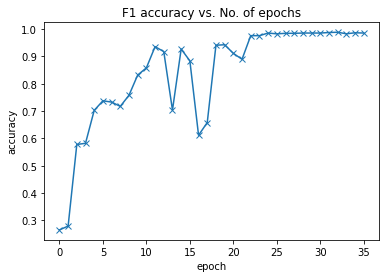

In [29]:
plot_accuracy(history)

Visualization of the training and validation losses. It shows that the model isn't overfitting to the training data.

In [30]:

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

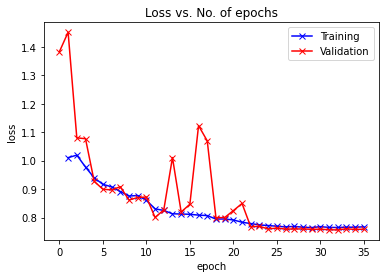

In [31]:
plot_losses(history)

This graph shows how the learning rate changed over time, every batch ovrt all the epochs

In [32]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

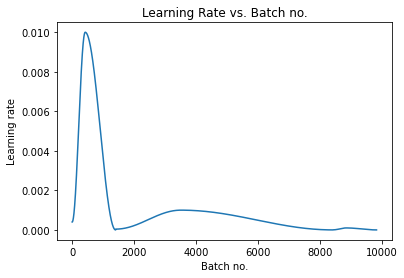

In [33]:
plot_lrs(history)

## Testing the model

The model reaches an accuracy of around 98% on the training dataset. But it's more important how the model works with some unknown dataset. Let's test the model with some images from the prededfined test dataset: 

In [34]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Lable: EOSINOPHIL , Predicted: EOSINOPHIL


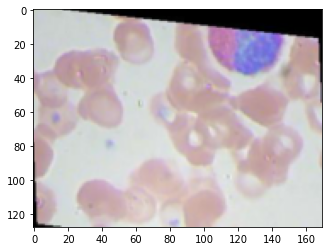

In [37]:
img, label = test_ds[4]
plt.imshow(img.permute(1, 2, 0))
print('Lable:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Lable: LYMPHOCYTE , Predicted: LYMPHOCYTE


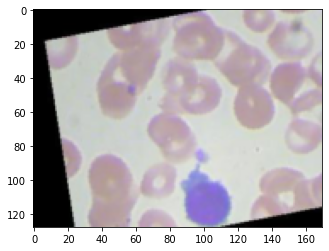

In [38]:
img, label = test_ds[1050]
plt.imshow(img.permute(1, 2, 0))
print('Lable:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Finally let's look at the overall loss and accuracy of the model on the test set.

In [39]:
test_loader = DeviceDataLoader(DataLoader(test_ds, BATCH_SIZE*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8837722539901733, 'val_acc': 0.8545745611190796}

The accuracy on the testing dataset is 85%. The result is pretty good but worse then on the validation dataset. Possibly because testing set isn't as similar as the validation set

## Save model

In [40]:
model_name = 'blood_cells_v7.pth'
torch.save(model.state_dict(), model_name)

## Save to jovian

In [41]:
arch = "resnet18, v7"
lrs = ["0.01", "0.001", "0.0001"]
epochs = [10, 20, 5]
score = history[-1]['val_acc']

In [42]:
!pip install jovian --upgrade --quiet

In [43]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)
jovian.log_metrics(val_score=score)
jovian.commit(project='blood_cells_classification')

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.
[jovian] Metrics logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/akovalyo/blood_cells_classification


<IPython.core.display.Javascript object>

# Conclusion

The final result was achieved by trying different variants of ResNet, different hyperparameters. This project showed that it is not so difficult to write code, but to obtain the good results it's important to choose the right model and train NN with different parameters.

I see that there is a lot of opportunities to apply machine learning in different fields, especially in medicine. I'm looking forward to diving deeper into this topic.  
During the course "Zero to GANs" I've learned the main concepts in deep learning 


# References

* Course material [zerotogans.org](http://zerotogans.org/)

* [Residual blocks — Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)

* [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

* [The One Cycle Learning Rate Policy](https://sgugger.github.io/the-1cycle-policy.html)

* [Weight Decay](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* [What is Gradient Clipping?](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48)